# TAXI TRIP DURATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [2]:
# Load training dataset
df_train = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/train.zip")
df_train.head(7)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341


In [3]:
# Get the shape of the DataFrame
Shape = df_train.shape
print(f"Shape of Data => {Shape}")

Shape of Data => (1458644, 11)


In [4]:
# Data types of each column in the DataFrame
df_train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [7]:
df_train[['passenger_count','trip_duration','vendor_id']].describe()

,passenger_count,trip_duration,vendor_id
count,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.664530e+00,9.594923e+02,1.534950e+00
std,1.314242e+00,5.237432e+03,4.987772e-01
min,0.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,3.970000e+02,1.000000e+00
50%,1.000000e+00,6.620000e+02,2.000000e+00
75%,2.000000e+00,1.075000e+03,2.000000e+00
max,9.000000e+00,3.526282e+06,2.000000e+00


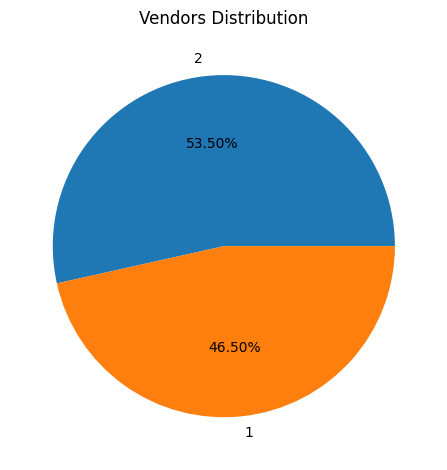

In [8]:
vendor_counts = df_train['vendor_id'].value_counts()

plt.pie(vendor_counts, labels=vendor_counts.index, autopct='%1.2f%%')

plt.title('Vendors Distribution')
plt.tight_layout()
plt.show()

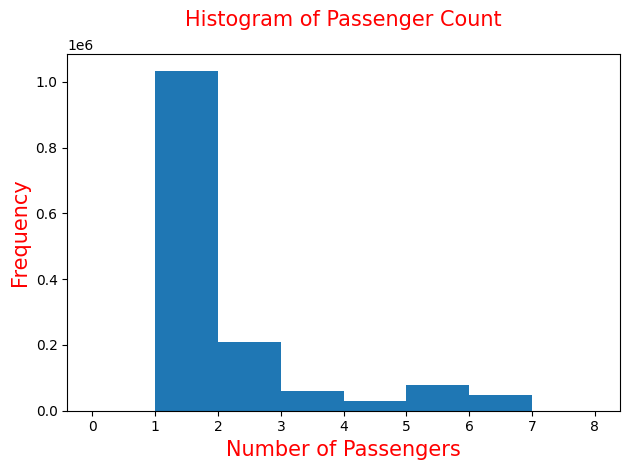

In [9]:
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(df_train['passenger_count'], bins=range(df_train['passenger_count'].min(), df_train['passenger_count'].max()))

# Set the title and labels
plt.title('Histogram of Passenger Count',pad =20,color = "red",size=15)
plt.xlabel('Number of Passengers',color = "red",size=15)
plt.ylabel('Frequency',color = "red",size=15)

# Show the plot
plt.tight_layout()
plt.show()


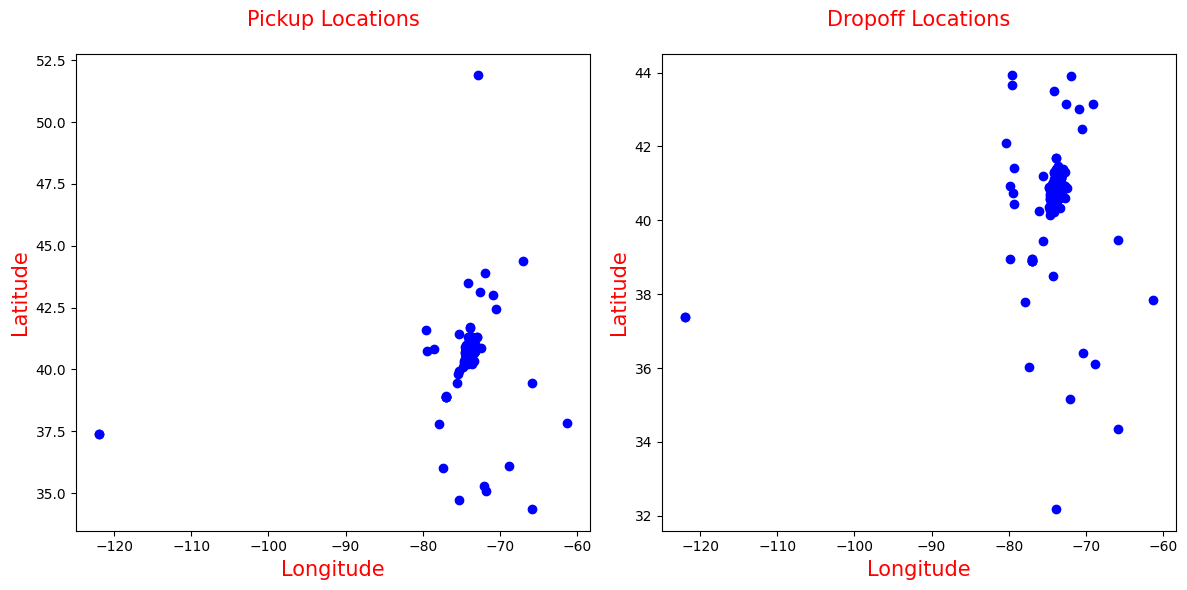

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_train['pickup_longitude'], df_train['pickup_latitude'],color = "blue")
plt.title('Pickup Locations',pad =20,color = "red",size=15)
plt.xlabel('Longitude',color = "red",size=15)
plt.ylabel('Latitude',color = "red",size=15)

plt.subplot(1, 2, 2)
plt.scatter(df_train['dropoff_longitude'], df_train['dropoff_latitude'],color = "blue")
plt.title('Dropoff Locations',pad =20,color = "red",size=15)
plt.xlabel('Longitude',color = "red",size=15)
plt.ylabel('Latitude',color = "red",size=15)

plt.tight_layout()
plt.show()


In [11]:
# Convert datetime and extract time-related features
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train['pickup_day'] = df_train['pickup_datetime'].dt.day_name()
df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train['pickup_month'] = df_train['pickup_datetime'].dt.month


In [12]:
# Label Encoding for categorical features
label_encode = LabelEncoder()
df_train['store_and_fwd_flag_encoded'] = label_encode.fit_transform(df_train['store_and_fwd_flag'])
df_train['pickup_day_encoded'] = label_encode.fit_transform(df_train['pickup_day'])

In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


df_train['distance'] = haversine_distance(df_train['pickup_latitude'], df_train['pickup_longitude'],
                                          df_train['dropoff_latitude'], df_train['dropoff_longitude'])

# Calculate speed (in km/h)
df_train['speed'] = np.where(df_train['trip_duration'] > 0,
                             df_train['distance'] / (df_train['trip_duration'] / 3600), 0)

# Outlier Removal: Filter trips with extreme trip durations
df_train = df_train[(df_train['trip_duration'] > 70) & (df_train['trip_duration'] < 7000)]

# Log transformation of the target variable (trip_duration)
df_train['log_trip_duration'] = np.log1p(df_train['trip_duration'])

X = df_train[['vendor_id', 'store_and_fwd_flag_encoded', 'pickup_day_encoded', 'pickup_hour',
              'pickup_month', 'distance', 'passenger_count', 'speed']]
T = df_train['log_trip_duration']

In [14]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, t_train, t_test = train_test_split(X_scaled, T, test_size=0.2, random_state=42)

ridge_model = Ridge()
param_grid = {'alpha': [0.1, 0.01, 0.001, 1]}
grid_search = GridSearchCV(ridge_model, param_grid, cv=4, scoring='r2')
grid_search.fit(X_scaled, T)

r2_scores_ridge_cv = cross_val_score(grid_search.best_estimator_, X_scaled, T, cv=4, scoring='r2')
